In [17]:
from pathlib import Path
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this

from datatype_recovery.models.dataset.balance import plot_dataset_balance

from datatype_recovery.models.dataset.encoding import TypeSequence
#pd.DataFrame([(",".join(x), 0.0) for x in TypeSequence().valid_type_sequences_for_len(2)], columns=['TypeSeq_Debug', 'Count'])

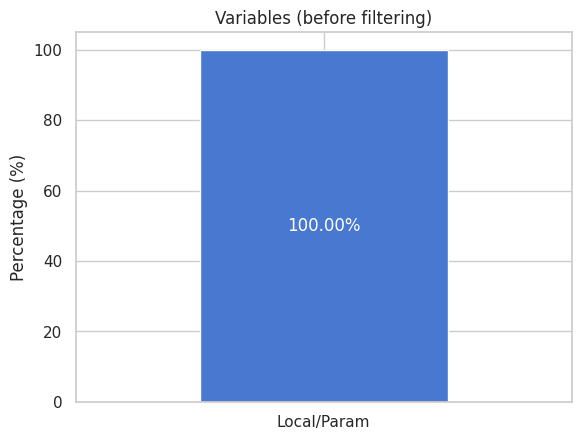

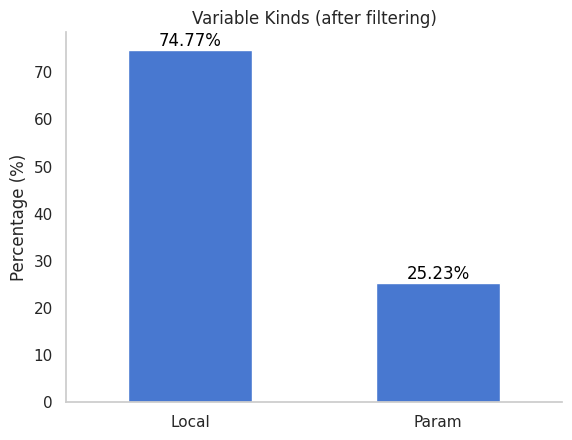

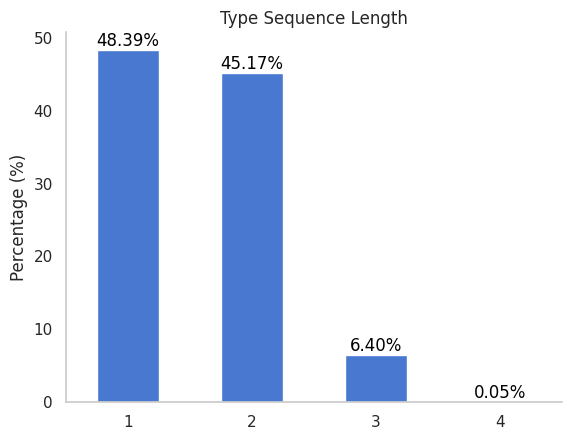

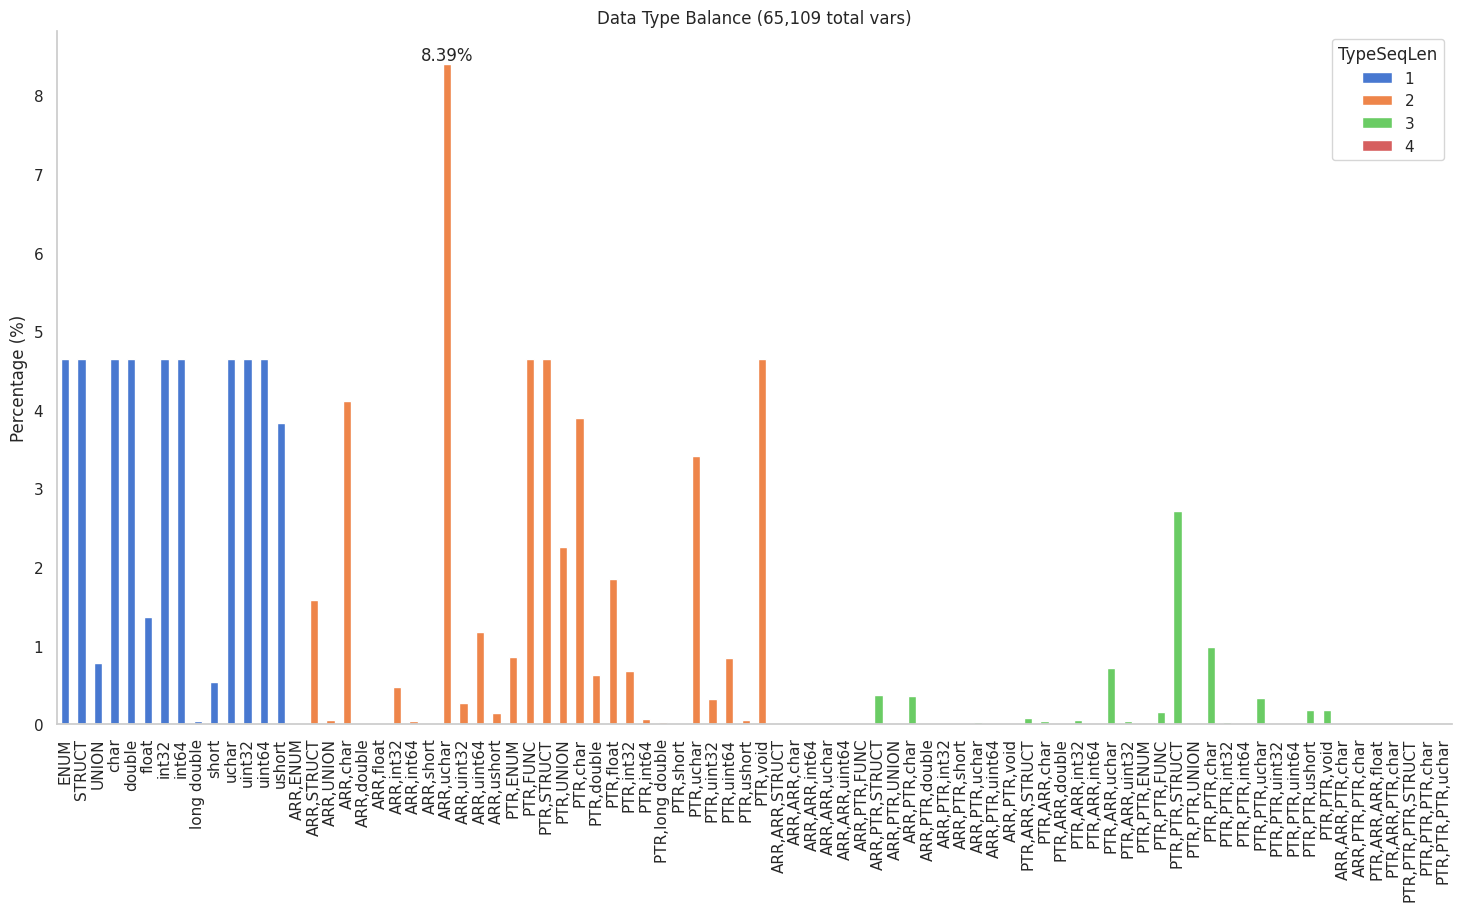

In [18]:
# ----------------------------------------------------------
# parameters
# dataset_path = Path.home()/'datasets/trainset_astera_full_5hops_nocomp'
# dataset_path = Path.home()/'datasets/trainset_astera_ffmpeg'
# dataset_path = Path.home()/'datasets/coreutils_full_5hops'
dataset_path = Path.home()/'datasets/trainset_bigger'
drop_comp = True
drop_return_types = True    # right now TypeSeqDatset is doing this
# ----------------------------------------------------------

# context: talk, notebook, paper, poster
# palette: muted, Paired, hls, husl, pastel, bright, deep, dark, colorblind
sns.set_theme(style='whitegrid', context='notebook', palette='muted')

var_df, bal_df = plot_dataset_balance(dataset_path, drop_comp, drop_return_types)

In [19]:
[(bal_df.index[i], val) for i, val in enumerate(bal_df.sum(axis=1))]

# bal_df[~bal_df[1].isna()]
lookup = {}
for i in range(1, bal_df.columns.max()+1):
    lookup[str(i)] = [(bal_df.index[i], val) for i, val in enumerate(bal_df[i])]
lookup.keys()

dict_keys(['1', '2', '3', '4'])

In [20]:
#plot_typeseq_len(bal_df)
#plot_full_dataset_balance(bal_df)
test = bal_df*len(var_df)
var_df.groupby('TypeSeq_Debug').count()[['BinaryId']].sort_values('BinaryId')

from datatype_recovery.models.dataset.encoding import TypeSequence

# keep all 1-element sequences, apply the projection from 2-element sequences and up



# maybe exclude void from consideration after 2-seq?

valid_sequences = TypeSequence().valid_type_sequences_for_len(3)

from typing import List, Dict



    # if len(seq) > 1:
    #     projected_seq.append([projection_2ndlevel[x] if x in projection_2ndlevel else x for x in seq])
    # else:
    #     projected_seq.append([projection_1stlevel[x] if x in projection_1stlevel else x for x in seq])


# sorted(list(x.split(',') for x in set(",".join(x) for x in projected_seq)), key=lambda x: f'{len(x)}{",".join(x)}')
projected_seq = [project_typesequence(s, projection) for s in valid_sequences]
projected_seq

var_df.TypeSeq_Debug
var_df['Projection'] = var_df.TypeSeq_Debug.apply(lambda x: ",".join(project_typesequence(x.split(','), projection, drop_after_len=2)))

NameError: name 'project_typesequence' is not defined

In [ ]:
var_df = var_df.loc[var_df.TypeSeq_Debug!='FUNC',:]

In [ ]:
#len(set(",".join(x) for x in projected_seq))
proj_classes = var_df.groupby('Projection').count()[['BinaryId']].index.to_list()

all_proj_classes = set([",".join(x) for x in projected_seq])

len(all_proj_classes)

all_proj_classes - set(proj_classes)
min_value = var_df.groupby('Projection').count().BinaryId.sort_values().iloc[0]
print(f'Balance with {min_value} samples per class')

var_df.groupby('Projection').count().BinaryId.sort_values()

In [ ]:
var_df[var_df.TypeSeq_Debug.isin(['ushort','STRUCT'])]

In [ ]:
balanced_df = var_df.groupby('Projection').sample(n=min_value, random_state=33)
percent_dropped = 100-len(balanced_df)/len(var_df)*100
print(f'Dropped {percent_dropped:.2f}% of the original dataset (from {len(var_df):,} down to {len(balanced_df):,})')


In [ ]:
balanced_df
dataset = load_dataset_from_path(dataset_path)
dataset

In [ ]:
dataset[0].varid

In [ ]:
balanced_df['VarID'] = balanced_df.apply(lambda x: (x.BinaryId, x.FunctionStart, x.Signature, x.Vartype), axis=1)

In [ ]:
balanced_varids = balanced_df.VarID.to_list()

balanced_indices = [i for i in range(len(dataset)) if dataset[i].varid in balanced_varids]
balanced_indices

In [ ]:
balanced_df.groupby('TypeSeq_Debug').count()[['BinaryId']].plot(kind='bar', figsize=(18,9))

In [ ]:
balanced_df.groupby('Projection').count()[['BinaryId']]

In [ ]:
for i in range(1, 5):
    print(f'{len(TypeSequence().valid_type_sequences_for_len(i))} valid types for sequence of length {i}')

In [ ]:
max_seq_len = 4
num_over_maxlen = counts[counts.TypeSeqLen>max_seq_len].BinaryId.sum()
print(f'{num_over_maxlen:,} of {len(var_df):,} variables exceeded max length of {max_seq_len} ({num_over_maxlen/len(var_df)*100:.3f}%)')

In [ ]:
var_df.loc[:,'TSL_Debug'] = var_df.TypeSeq_Debug.apply(lambda ts: len(ts.split(',')))
var_df[(var_df.HasDWARF)&(var_df.TSL_Debug<=1)].groupby('TypeSeq_Debug').count().sort_values('BinaryId')

In [ ]:
ordered_idx = sorted(counts.index, key=lambda x: f'{len(x.split(","))}{x}')
max_true_len = var_df.TypeSeq_Debug.apply(lambda ts: len(ts.split(','))).max()
var_df[var_df.TypeSeq_Debug.apply(lambda ts: len(ts.split(',')) >= 5)]

In [ ]:
perc_df = (counts.loc[ordered_idx][['BinaryId']]/len(var_df)*100)
# .plot(kind='bar')
perc_df[perc_df.BinaryId>=4].plot(kind='bar')

In [ ]:
perc_df.sort_values('BinaryId')

In [ ]:
var_df[var_df.TypeSeq_Debug=='FUNC']

In [ ]:
# TODO: normalize Ghidra's FUNC var types to be PTR,FUNC for consistency

from varlib.datatype import datatype_from_json_str, PointerType

ftype = datatype_from_json_str(var_df[var_df.TypeSeq_Debug=='FUNC'].TypeJson_Debug.iloc[0])
ftype
PointerType(ftype, pointer_size=8)